# Conceptual Design of Ultra-Supercritical Power Plant Integrated with Thermal Energy Storage System

Author: Edna Soraya Rawlings, esrawli@sandia.gov

This notebook describes the design of an ultra-supercritical thermal power plant integrated with a thermal energy storage (TES) system during charge and discharge cycles. In this tutorial, we describe two superstructure models to determine the conceptual design of the TES using a Generalized Disjunctive Programming (GDP) formulation. Both models consider two types of design variables: discrete, included to identify the optimal integration points of the charge and discharge heat exchangers in the power plant, and continuous, included to determine the area and operating conditions of the storage system. The discrete design variables are included in the model as logical constraints using disjunctions. 

To design the storage system to integrate to the power plant, two superstructures are built: one to charge and one to discharge the TES.  For the construction of the two GDP model superstructures, the model of the ultra-supercritical power plant described in the documentation `Ultra-Supercritical Power Plant`, is used as the base model and it is available in the DISPATCHES repository as `ultra_supercritical_powerplant.py`. We start by describing the construction and solution of the GDP charge superstructure, followed by the solution of the GDP discharge superstructure.

## Charge Superstructure

The charge cycle includes a storage heat exchanger `HXC`, a splitter `CS`, a cooler, a pump `SP`, and a recycle mixer to the power plant. A conceptual representation of the charge superstructure is shown in the flowsheet below, where the green dotted and dashed lines represent the discrete design decisions of the charge cycle when integrated with the power plant. The charge superstructure includes two disjunctions: 1) Selection of Solar salt, Hitec salt, or thermal oil as the heat transfer fluid in the charge heat exchanger (shown in the dashed dotted green lines in the figure below), and 2) selection between a very high-pressure or a high-pressure steam as the steam source to heat up the heat transfer fluid (shown in the dashed green lines in the figure below). In this example, the charge superstructure consists of six different flowsheet configurations.

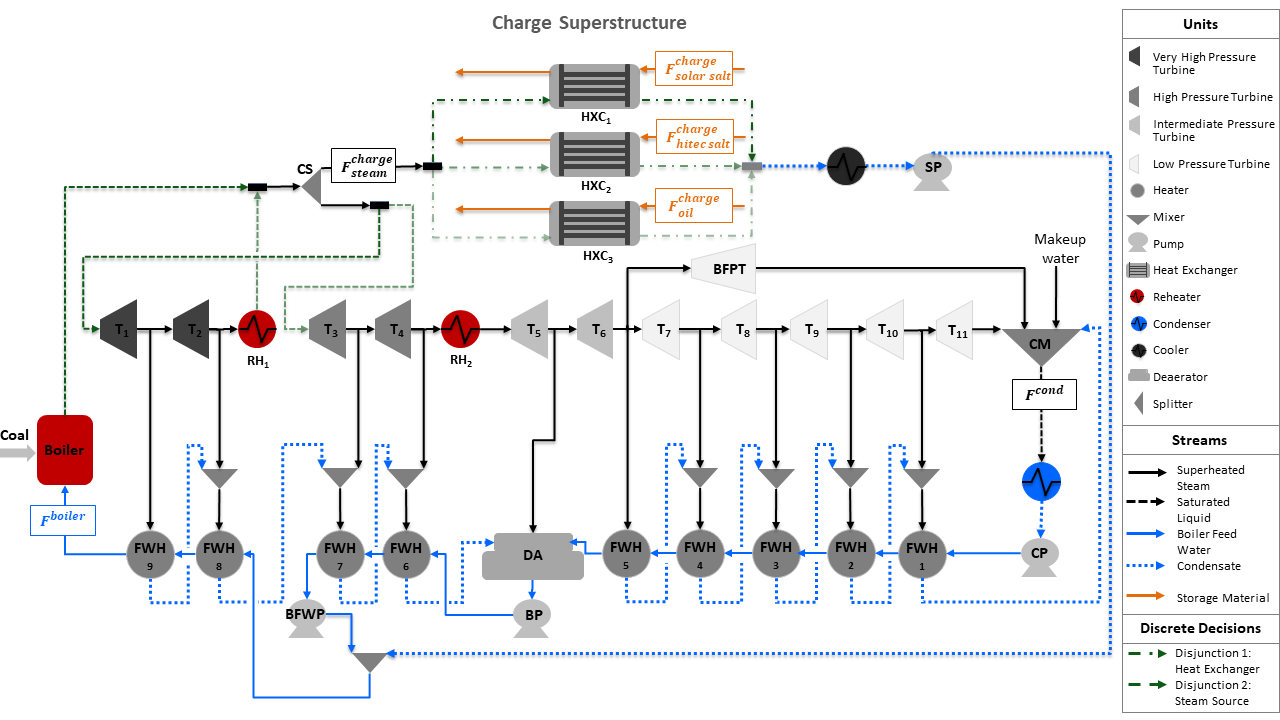

To start the construction of the charge design model, import all the Pyomo and IDAES libraries and packages needed in the model.

In [1]:
import pyomo.environ as pyo
from pyomo.environ import (Block, Param, Constraint, Objective,
                           TransformationFactory, SolverFactory,
                           Expression, value, log, exp, Var)
from pyomo.environ import units as pyunits
from pyomo.network import Arc
from pyomo.common.fileutils import this_file_dir
from pyomo.util.calc_var_value import calculate_variable_from_constraint
from pyomo.gdp import Disjunct, Disjunction
from pyomo.network.plugins import expand_arcs
from pyomo.contrib.fbbt.fbbt import  _prop_bnds_root_to_leaf_map
from pyomo.core.expr.numeric_expr import ExternalFunctionExpression

import idaes.core.util.scaling as iscale
import idaes.logger as idaeslog
from idaes.core import MaterialBalanceType
from idaes.core.util.initialization import propagate_state
from idaes.core.solvers.get_solver import get_solver
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.models.unit_models import (HeatExchanger,
                                      MomentumMixingType,
                                      Heater,
                                      Mixer,
                                      PressureChanger)
from idaes.models.unit_models.separator import (Separator,
                                                SplittingType)
from idaes.models.unit_models.heat_exchanger import (delta_temperature_underwood_callback,
                                                     HeatExchangerFlowPattern)
from idaes.models.unit_models.pressure_changer import ThermodynamicAssumption
from idaes.models_extra.power_generation.unit_models.helm import (HelmMixer,
                                                                  HelmIsentropicCompressor,
                                                                  HelmTurbineStage,
                                                                  HelmSplitter)
from idaes.models.costing.SSLW import (
    SSLWCosting,
    SSLWCostingData,
    PumpType,
    PumpMaterial,
    PumpMotorType,
)
from idaes.core.util.exceptions import ConfigurationError

Import the property packages of Solar salt, Hitec salt, and thermal oil as heat transfer fluids to be used in the charge heat exchanger.

In [2]:
from dispatches.models.fossil_case.properties import (solarsalt_properties,
                                                      hitecsalt_properties,
                                                      thermaloil_properties)

Import the ultra-supercritical power plant model `ultra_supercritical_powerplant.py` as `usc` to be used as the base model to integrate the charge cycle. More details about this model can be found in the notebook `ultrasupercritical_power_plant`, also available in the DISPATCHES repository.

In [3]:
from dispatches.models.fossil_case.ultra_supercritical_plant import ultra_supercritical_powerplant as usc

Import the charge design model `charge_design_ultra_supercritical_power_plant.py`, available in the DISPATCHES repository, as `c_usc`.

In [4]:
from dispatches.models.fossil_case.ultra_supercritical_plant.storage import charge_design_ultra_supercritical_power_plant as c_usc

After importing all libraries, packages, and models, build the ultra-supercritical power plant base model by calling the method `build_plant_model` from the ultra-supercritical plant model `usc` and initialize it using the `initialize` method.

In [5]:
m = usc.build_plant_model()

usc.initialize(m, outlvl=idaeslog.WARNING)

Model Initialization =  optimal
*******************  USC Model Initialized   ********************


Add property packages for the Solar salt, Hitec salt, and thermal oil, which are used as the heat transfer fluids alternatives in the charge heat exchanger.

In [6]:
m.fs.solar_salt_properties = solarsalt_properties.SolarsaltParameterBlock()
m.fs.hitec_salt_properties = hitecsalt_properties.HitecsaltParameterBlock()
m.fs.therminol66_properties = thermaloil_properties.ThermalOilParameterBlock()

Disconnect units from the ultra-supercritical power plant base model to connect the units in the charge cycle.

In [7]:
for arc_s in [m.fs.boiler_to_turb1,
              m.fs.bfp_to_fwh8,
              m.fs.rh1_to_turb3]:
    arc_s.expanded_block.enth_mol_equality.deactivate()
    arc_s.expanded_block.flow_mol_equality.deactivate()
    arc_s.expanded_block.pressure_equality.deactivate()

Declare a block `charge` in the flowsheet model to include the units, constraints, and discrete decisions (as disjunctions) needed in the charge cycle.

In [8]:
m.fs.charge = Block()

Add needed data using the method `_add_data` from the design charge model `c_usc`. The method includes values for operating and design variables and costs for fuel and storage system units. Also, declare the maximum power that can be produced in the power plant. 

In [9]:
c_usc._add_data(m)

power_max = 436

Declare a connector, a cooler, a pump, and a recycle mixer unit, as the units in the charge cycle. Note that the charge heat exchanger is not included here since it would be included as a design decision.  

In [10]:
m.fs.charge.connector = Heater(
    default={"dynamic": False,
             "property_package": m.fs.prop_water,
             "has_pressure_change": False})
m.fs.charge.cooler = Heater(
    default={"dynamic": False,
             "property_package": m.fs.prop_water,
             "has_pressure_change": True})
m.fs.charge.hx_pump = PressureChanger(
    default={"property_package": m.fs.prop_water,
             "material_balance_type": MaterialBalanceType.componentTotal,
             "thermodynamic_assumption": ThermodynamicAssumption.pump})
m.fs.charge.recycle_mixer = HelmMixer(
    default={"momentum_mixing_type": MomentumMixingType.none,
             "inlet_list": ["from_bfw_out", "from_hx_pump"],
             "property_package": m.fs.prop_water})

Use the modeling component `Arc` to connect the cooler, pump, and recycle mixer to the power plant.

In [11]:
m.fs.charge.cooler_to_hxpump = Arc(
    source=m.fs.charge.cooler.outlet,
    destination=m.fs.charge.hx_pump.inlet,
    doc="Connection from cooler to HX pump"
)
m.fs.charge.hxpump_to_recyclemix = Arc(
    source=m.fs.charge.hx_pump.outlet,
    destination=m.fs.charge.recycle_mixer.from_hx_pump,
    doc="Connection from HX pump to recycle mixer"
)
m.fs.charge.bfp_to_recyclemix = Arc(
    source=m.fs.bfp.outlet,
    destination=m.fs.charge.recycle_mixer.from_bfw_out,
    doc="Connection from BFP outlet to recycle mixer"
)
m.fs.charge.recyclemix_to_fwh8 = Arc(
    source=m.fs.charge.recycle_mixer.outlet,
    destination=m.fs.fwh[8].inlet_2,
    doc="Connection from recycle mixer to FWH8 tube side"
)

Declare the Solar salt, Hitec salt, and thermal oil as alternatives for the charge storage system using Pyomo `Disjunct` and `Disjunction` modeling objects. The disjuncts represent the discrete decision for the selection of the heat transfer fluid to use in the charge heat exchanger and are included in disjunction 1 as the discrete decisions.

In [12]:
m.fs.charge.solar_salt_disjunct = Disjunct()
m.fs.charge.hitec_salt_disjunct = Disjunct()
m.fs.charge.thermal_oil_disjunct = Disjunct()

m.fs.salt_disjunction = Disjunction(
    expr=[m.fs.charge.solar_salt_disjunct,
          m.fs.charge.hitec_salt_disjunct,
          m.fs.charge.thermal_oil_disjunct]
)

Populate each disjunct with a set of units and equations. For each heat transfer fluid disjunct, declare a charge heat exchanger `HXC` that uses either Solar salt, Hitec salt, or thermal oil as the heat transfer fluid. Each disjunct contains a set of expressions for the calculation of the overall heat transfer coefficient, including equations to calculate the Reynolds, Prandtl, and Nusslet number. Start by populating the Solar salt disjunct.

In [13]:
m.fs.charge.solar_salt_disjunct.hxc = HeatExchanger(
    default={"delta_temperature_callback": delta_temperature_underwood_callback,
             "shell": {"property_package": m.fs.prop_water},
             "tube": {"property_package": m.fs.solar_salt_properties}})

solar_hxc = m.fs.charge.solar_salt_disjunct.hxc

m.fs.charge.solar_salt_disjunct.hxc.salt_reynolds_number = pyo.Expression(
    expr=((solar_hxc.inlet_2.flow_mass[0] *
           m.fs.charge.hxc_tube_outer_dia) /
          (m.fs.charge.hxc_shell_eff_area *
           solar_hxc.side_2.properties_in[0].visc_d_phase["Liq"])
    ),
    doc="Salt Reynolds Number")
m.fs.charge.solar_salt_disjunct.hxc.salt_prandtl_number = pyo.Expression(
    expr=(
        solar_hxc.side_2.properties_in[0].cp_mass["Liq"] *
        solar_hxc.side_2.properties_in[0].visc_d_phase["Liq"] /
        solar_hxc.side_2.properties_in[0].therm_cond_phase["Liq"]
    ),
    doc="Salt Prandtl Number")
m.fs.charge.solar_salt_disjunct.hxc.salt_prandtl_wall = pyo.Expression(
    expr=(
        solar_hxc.side_2.properties_out[0].cp_mass["Liq"] *
        solar_hxc.side_2.properties_out[0].visc_d_phase["Liq"] /
        solar_hxc.side_2.properties_out[0].therm_cond_phase["Liq"]
    ),
    doc="Salt Prandtl Number at wall")
m.fs.charge.solar_salt_disjunct.hxc.salt_nusselt_number = pyo.Expression(
    expr=(
        0.35 *
        (solar_hxc.salt_reynolds_number**0.6) *
        (solar_hxc.salt_prandtl_number**0.4) *
        ((solar_hxc.salt_prandtl_number /
          solar_hxc.salt_prandtl_wall)**0.25) * (2**0.2)
    ),
    doc="Salt Nusslet Number from 2019, App Ener (233-234), 126")
m.fs.charge.solar_salt_disjunct.hxc.steam_reynolds_number = pyo.Expression(
    expr=(
        solar_hxc.inlet_1.flow_mol[0] *
        solar_hxc.side_1.properties_in[0].mw *
        m.fs.charge.hxc_tube_inner_dia / (
            m.fs.charge.hxc_tube_cs_area *
            m.fs.charge.hxc_n_tubes *
            solar_hxc.side_1.properties_in[0].visc_d_phase["Vap"]
        )
    ),
    doc="Steam Reynolds Number")
m.fs.charge.solar_salt_disjunct.hxc.steam_prandtl_number = pyo.Expression(
    expr=(
        (solar_hxc.side_1.properties_in[0].cp_mol /
         solar_hxc.side_1.properties_in[0].mw) *
        solar_hxc.side_1.properties_in[0].visc_d_phase["Vap"] /
        solar_hxc.side_1.properties_in[0].therm_cond_phase["Vap"]
    ),
    doc="Steam Prandtl Number")
m.fs.charge.solar_salt_disjunct.hxc.steam_nusselt_number = pyo.Expression(
    expr=(
        0.023 *
        (solar_hxc.steam_reynolds_number**0.8) *
        (solar_hxc.steam_prandtl_number**(0.33)) *
        ((solar_hxc.side_1.properties_in[0].visc_d_phase["Vap"] /
          solar_hxc.side_1.properties_out[0].visc_d_phase["Liq"])**0.14)
    ),
    doc="Steam Nusslet Number from 2001 Zavoico, Sandia")
m.fs.charge.solar_salt_disjunct.hxc.h_salt = pyo.Expression(
    expr=(
        solar_hxc.side_2.properties_in[0].therm_cond_phase["Liq"] *
        solar_hxc.salt_nusselt_number /
        m.fs.charge.hxc_tube_outer_dia
    ),
    doc="Salt side convective heat transfer coefficient in W/mK")
m.fs.charge.solar_salt_disjunct.hxc.h_steam = pyo.Expression(
    expr=(
        solar_hxc.side_1.properties_in[0].therm_cond_phase["Vap"] *
        solar_hxc.steam_nusselt_number /
        m.fs.charge.hxc_tube_inner_dia
    ),
    doc="Steam side convective heat transfer coefficient in W/mK")

m.fs.charge.solar_salt_disjunct.hxc.constraint_hxc_ohtc = Constraint(
    expr=(
        (solar_hxc.overall_heat_transfer_coefficient[0] * (
            2 * m.fs.charge.hxc_k_steel *
            solar_hxc.h_steam +
            m.fs.charge.hxc_tube_outer_dia *
            m.fs.charge.hxc_log_tube_dia_ratio *
            solar_hxc.h_salt *
            solar_hxc.h_steam +
            m.fs.charge.hxc_tube_dia_ratio *
            solar_hxc.h_salt *
            2 * m.fs.charge.hxc_k_steel)) == (
                2 * m.fs.charge.hxc_k_steel *
                solar_hxc.h_salt *
                solar_hxc.h_steam
            )
    ),
    doc="Overall heat transfer coefficient for Solar salt heat exchanger"
)


After the calculation of the overall heat transer coefficient, connect the Solar salt charge heat exchanger to the power plant using `Arcs`. Note that this connection occurs only when the disjunct is selected.

In [14]:
m.fs.charge.solar_salt_disjunct.connector_to_hxc = Arc(
    source=m.fs.charge.connector.outlet,
    destination=solar_hxc.inlet_1,
    doc="Connection from connector to solar charge heat exchanger"
)
m.fs.charge.solar_salt_disjunct.hxc_to_cooler = Arc(
    source=solar_hxc.outlet_1,
    destination=m.fs.charge.cooler.inlet,
    doc="Connection from cooler to solar charge heat exchanger"
)

Following the same strategy as in the Solar salt disjunct, populate the Hitec salt and thermal oil disjuncts by first declaring a heat exchanger, followed by the calculation of the overall heat transfer coefficient, and finally the addition of `Arcs` to connect each charge heat exchanger to the power plant.

In [15]:
m.fs.charge.hitec_salt_disjunct.hxc = HeatExchanger(
    default={"delta_temperature_callback": delta_temperature_underwood_callback,
             "shell": {"property_package": m.fs.prop_water},
             "tube": {"property_package": m.fs.hitec_salt_properties}}
)

hitec_hxc = m.fs.charge.hitec_salt_disjunct.hxc

m.fs.charge.hitec_salt_disjunct.hxc.salt_reynolds_number = pyo.Expression(
    expr=(hitec_hxc.inlet_2.flow_mass[0] *
          m.fs.charge.hxc_tube_outer_dia /
          (m.fs.charge.hxc_shell_eff_area *
           hitec_hxc.side_2.properties_in[0].visc_d_phase["Liq"])),
    doc="Salt Reynolds Number"
)
m.fs.charge.hitec_salt_disjunct.hxc.salt_prandtl_number = pyo.Expression(
    expr=(
        hitec_hxc.side_2.properties_in[0].cp_mass["Liq"] *
        hitec_hxc.side_2.properties_in[0].visc_d_phase["Liq"] /
        hitec_hxc.side_2.properties_in[0].therm_cond_phase["Liq"]
    ),
    doc="Salt Prandtl Number")
m.fs.charge.hitec_salt_disjunct.hxc.salt_prandtl_wall = pyo.Expression(
    expr=(
        hitec_hxc.side_2.properties_out[0].cp_mass["Liq"] *
        hitec_hxc.side_2.properties_out[0].visc_d_phase["Liq"] /
        hitec_hxc.side_2.properties_out[0].therm_cond_phase["Liq"]
    ),
    doc="Salt Wall Prandtl Number"
)
m.fs.charge.hitec_salt_disjunct.hxc.salt_nusselt_number = pyo.Expression(
    expr=(
        1.61 *
        ((hitec_hxc.salt_reynolds_number *
          hitec_hxc.salt_prandtl_number * 0.009)**0.63) *
        ((hitec_hxc.side_2.properties_in[0].visc_d_phase["Liq"] /
          hitec_hxc.side_2.properties_out[0].visc_d_phase["Liq"])**0.25)
    ),
    doc="Salt Nusslet Number from 2014, He et al, Exp Therm Fl Sci, 59, 9"
)
m.fs.charge.hitec_salt_disjunct.hxc.steam_reynolds_number = pyo.Expression(
    expr=(
        hitec_hxc.inlet_1.flow_mol[0] *
        hitec_hxc.side_1.properties_in[0].mw *
        m.fs.charge.hxc_tube_inner_dia / (
            m.fs.charge.hxc_tube_cs_area *
            m.fs.charge.hxc_n_tubes *
            hitec_hxc.side_1.properties_in[0].visc_d_phase["Vap"]
        )
    ),
    doc="Steam Reynolds Number"
)
m.fs.charge.hitec_salt_disjunct.hxc.steam_prandtl_number = pyo.Expression(
    expr=(
        (hitec_hxc.side_1.properties_in[0].cp_mol /
         hitec_hxc.side_1.properties_in[0].mw) *
        hitec_hxc.side_1.properties_in[0].visc_d_phase["Vap"] /
        hitec_hxc.side_1.properties_in[0].therm_cond_phase["Vap"]
    ),
    doc="Steam Prandtl Number"
)
m.fs.charge.hitec_salt_disjunct.hxc.steam_nusselt_number = pyo.Expression(
    expr=(
        0.023 *
        (hitec_hxc.steam_reynolds_number**0.8) *
        (hitec_hxc.steam_prandtl_number**0.33) *
        ((hitec_hxc.side_1.properties_in[0].visc_d_phase["Vap"] /
          hitec_hxc.side_1.properties_out[0].visc_d_phase["Liq"])**0.14)
    ),
    doc="Steam Nusslet Number from 2001 Zavoico, Sandia"
)

m.fs.charge.hitec_salt_disjunct.hxc.h_salt = pyo.Expression(
    expr=(
        hitec_hxc.side_2.properties_in[0].therm_cond_phase["Liq"] *
        hitec_hxc.salt_nusselt_number /
        m.fs.charge.hxc_tube_outer_dia
    ),
    doc="Salt side convective heat transfer coefficient in W/mK"
)
m.fs.charge.hitec_salt_disjunct.hxc.h_steam = pyo.Expression(
    expr=(
        hitec_hxc.side_1.properties_in[0].therm_cond_phase["Vap"] *
        hitec_hxc.steam_nusselt_number /
        m.fs.charge.hxc_tube_inner_dia
    ),
    doc="Steam side convective heat transfer coefficient in W/mK"
)

m.fs.charge.hitec_salt_disjunct.hxc.constraint_hxc_ohtc = Constraint(
    expr=(
        (hitec_hxc.overall_heat_transfer_coefficient[0] * (
            2 * m.fs.charge.hxc_k_steel *
            hitec_hxc.h_steam +
            m.fs.charge.hxc_tube_outer_dia *
            m.fs.charge.hxc_log_tube_dia_ratio *
            hitec_hxc.h_salt *
            hitec_hxc.h_steam +
            m.fs.charge.hxc_tube_dia_ratio *
            hitec_hxc.h_salt *
            2 * m.fs.charge.hxc_k_steel
        )) == (2 * m.fs.charge.hxc_k_steel *
               hitec_hxc.h_salt * hitec_hxc.h_steam)
    ),
    doc="Overall heat transfer coefficient for Hitec heat exchanger"
)

m.fs.charge.hitec_salt_disjunct.connector_to_hxc = Arc(
    source=m.fs.charge.connector.outlet,
    destination=hitec_hxc.inlet_1,
    doc="Connect the connector to Hitec heat exchanger"
)
m.fs.charge.hitec_salt_disjunct.hxc_to_cooler = Arc(
    source=hitec_hxc.outlet_1,
    destination=m.fs.charge.cooler.inlet,
    doc="Connect cooler to Hitec charge heat exchanger"
)

In [16]:
m.fs.charge.thermal_oil_disjunct.hxc = HeatExchanger(
    default={"delta_temperature_callback": delta_temperature_underwood_callback,
             "shell": {"property_package": m.fs.prop_water},
             "tube": {"property_package": m.fs.therminol66_properties},
             "flow_pattern": HeatExchangerFlowPattern.countercurrent}
)

thermal_hxc = m.fs.charge.thermal_oil_disjunct.hxc
m.fs.charge.thermal_oil_disjunct.hxc.oil_reynolds_number = pyo.Expression(
    expr=(
        thermal_hxc.inlet_2.flow_mass[0] *
        m.fs.charge.hxc_tube_outer_dia /
        (m.fs.charge.hxc_shell_eff_area *
         thermal_hxc.side_2.properties_in[0].visc_d_phase["Liq"])
    ),
    doc="Salt Reynolds Number"
)
m.fs.charge.thermal_oil_disjunct.hxc.oil_prandtl_number = pyo.Expression(
    expr=(
        thermal_hxc.side_2.properties_in[0].cp_mass["Liq"] *
        thermal_hxc.side_2.properties_in[0].visc_d_phase["Liq"] /
        thermal_hxc.side_2.properties_in[0].therm_cond_phase["Liq"]
    ),
    doc="Salt Prandtl Number")
m.fs.charge.thermal_oil_disjunct.hxc.oil_prandtl_wall = pyo.Expression(
    expr=(
        thermal_hxc.side_2.properties_out[0].cp_mass["Liq"] *
        thermal_hxc.side_2.properties_out[0].visc_d_phase["Liq"] /
        thermal_hxc.side_2.properties_out[0].therm_cond_phase["Liq"]
    ),
    doc="Salt Wall Prandtl Number"
)
m.fs.charge.thermal_oil_disjunct.hxc.oil_nusselt_number = pyo.Expression(
    expr=(
        0.36 * ((thermal_hxc.oil_reynolds_number**0.55) *
                (thermal_hxc.oil_prandtl_number**0.33) *
                ((thermal_hxc.oil_prandtl_number /
                  thermal_hxc.oil_prandtl_wall)**0.14))
    ),
    doc="Salt Nusslet Number from 2014, He et al, Exp Therm Fl Sci, 59, 9"
)
m.fs.charge.thermal_oil_disjunct.hxc.steam_reynolds_number = pyo.Expression(
    expr=(
        thermal_hxc.inlet_1.flow_mol[0] *
        thermal_hxc.side_1.properties_in[0].mw *
        m.fs.charge.hxc_tube_inner_dia / (
            m.fs.charge.hxc_tube_cs_area *
            m.fs.charge.hxc_n_tubes *
            thermal_hxc.side_1.properties_in[0].visc_d_phase["Vap"])
    ),
    doc="Steam Reynolds Number"
)
m.fs.charge.thermal_oil_disjunct.hxc.steam_prandtl_number = pyo.Expression(
    expr=(
        (thermal_hxc.side_1.properties_in[0].cp_mol /
         thermal_hxc.side_1.properties_in[0].mw) *
        thermal_hxc.side_1.properties_in[0].visc_d_phase["Vap"] /
        thermal_hxc.side_1.properties_in[0].therm_cond_phase["Vap"]
    ),
    doc="Steam Prandtl Number"
)
m.fs.charge.thermal_oil_disjunct.hxc.steam_nusselt_number = pyo.Expression(
    expr=(
        0.023 * (thermal_hxc.steam_reynolds_number**0.8) *
        (thermal_hxc.steam_prandtl_number**(0.33)) * (
            (thermal_hxc.side_1.properties_in[0].visc_d_phase["Vap"] /
             thermal_hxc.side_1.properties_out[0].visc_d_phase["Liq"])**0.14
        )
    ),
    doc="Steam Nusslet Number from 2001 Zavoico, Sandia"
)

m.fs.charge.thermal_oil_disjunct.hxc.h_oil = pyo.Expression(
    expr=(
        thermal_hxc.side_2.properties_in[0].therm_cond_phase["Liq"] *
        thermal_hxc.oil_nusselt_number /
        m.fs.charge.hxc_tube_outer_dia
    ),
    doc="Salt side convective heat transfer coefficient in W/mK"
)
m.fs.charge.thermal_oil_disjunct.hxc.h_steam = pyo.Expression(
    expr=(
        thermal_hxc.side_1.properties_in[0].therm_cond_phase["Vap"] *
        thermal_hxc.steam_nusselt_number /
        m.fs.charge.hxc_tube_inner_dia
    ),
    doc="Steam side convective heat transfer coefficient in W/mK"
)

m.fs.charge.thermal_oil_disjunct.hxc.constraint_hxc_ohtc = Constraint(
    expr=(
        thermal_hxc.overall_heat_transfer_coefficient[0] * (
            2 * m.fs.charge.hxc_k_steel *
            thermal_hxc.h_steam +
            m.fs.charge.hxc_tube_outer_dia *
            m.fs.charge.hxc_log_tube_dia_ratio *
            thermal_hxc.h_oil *
            thermal_hxc.h_steam +
            m.fs.charge.hxc_tube_dia_ratio *
            thermal_hxc.h_oil *
            2 * m.fs.charge.hxc_k_steel
        )
    ) == (
        2 * m.fs.charge.hxc_k_steel *
        thermal_hxc.h_oil *
        thermal_hxc.h_steam
    ),
    doc="Overall heat transfer coefficient for thermal oil heat exchanger"
)

m.fs.charge.thermal_oil_disjunct.connector_to_hxc = Arc(
    source=m.fs.charge.connector.outlet,
    destination=thermal_hxc.inlet_1,
    doc="Connection from connector to thermal oil charge heat exchanger"
)
m.fs.charge.thermal_oil_disjunct.hxc_to_cooler = Arc(
    source=thermal_hxc.outlet_1,
    destination=m.fs.charge.cooler.inlet,
    doc="Connection from cooler to thermal oil charge heat exchanger"
)

After declaring all units, constraints, and connections in disjunction 1, declare the discrete decisions in disjunction 2. In disjunction 2, two steam source alternatives are included as disjuncts. The first alternative is for the selection of a very high-pressure steam source from the boiler outlet and the second alternative is the selection of a high-pressure steam source from the reheater 1 outlet.

In [17]:
m.fs.charge.vhp_source_disjunct = Disjunct()
m.fs.charge.hp_source_disjunct = Disjunct()

m.fs.source_disjunction = Disjunction(
    expr=[m.fs.charge.vhp_source_disjunct,
          m.fs.charge.hp_source_disjunct]
)

Populate each steam source disjunct by including a splitter to divert a fraction of the steam to the storage system. Following this, declare a set of `Arcs` to connect the splitter to the power plant. Start by populating the very high-pressure steam source disjunct by declaring a splitter to divert a fraction of a very high-pressure steam from the boiler outlet, followed by the connection of the splitter to the boiler, turbine 1, and charge storage system using `Arcs`.

In [18]:
m.fs.charge.vhp_source_disjunct.ess_vhp_split = HelmSplitter(
    default={"property_package": m.fs.prop_water,
             "outlet_list": ["to_hxc", "to_turbine"]}
)

In [19]:
m.fs.charge.vhp_source_disjunct.boiler_to_essvhp = Arc(
    source=m.fs.boiler.outlet,
    destination=m.fs.charge.vhp_source_disjunct.ess_vhp_split.inlet,
    doc="Connection from boiler to hp splitter"
)
m.fs.charge.vhp_source_disjunct.essvhp_to_turb1 = Arc(
    source=m.fs.charge.vhp_source_disjunct.ess_vhp_split.to_turbine,
    destination=m.fs.turbine[1].inlet,
    doc="Connection from VHP splitter to turbine 1"
)
m.fs.charge.vhp_source_disjunct.vhpsplit_to_connector = Arc(
    source=m.fs.charge.vhp_source_disjunct.ess_vhp_split.to_hxc,
    destination=m.fs.charge.connector.inlet,
    doc="Connection from VHP splitter to connector"
)
m.fs.charge.vhp_source_disjunct.rh1_to_turb3 = Arc(
    source=m.fs.reheater[1].outlet,
    destination=m.fs.turbine[3].inlet,
    doc="Connection from reheater 1 to turbine 3"
)

Populate the second steam source in disjunction 2 or the high-pressure steam source. Declare a splitter to divert a fraction of the high-pressure steam from the reheater 1 outlet, and connect the splitter to the reheater 1, turbine 3, and storage system using `Arcs`.

In [20]:
m.fs.charge.hp_source_disjunct.ess_hp_split = HelmSplitter(
    default={"property_package": m.fs.prop_water,
             "outlet_list": ["to_hxc", "to_turbine"]}
)

m.fs.charge.hp_source_disjunct.rh1_to_esshp = Arc(
    source=m.fs.reheater[1].outlet,
    destination=m.fs.charge.hp_source_disjunct.ess_hp_split.inlet,
    doc="Connection from reheater to ip splitter"
)

m.fs.charge.hp_source_disjunct.esshp_to_turb3 = Arc(
    source=m.fs.charge.hp_source_disjunct.ess_hp_split.to_turbine,
    destination=m.fs.turbine[3].inlet,
    doc="Connection from HP splitter to turbine 3"
)

m.fs.charge.hp_source_disjunct.hpsplit_to_connector = Arc(
    source=m.fs.charge.hp_source_disjunct.ess_hp_split.to_hxc,
    destination=m.fs.charge.connector.inlet,
    doc="Connection from HP splitter to connector"
)

m.fs.charge.hp_source_disjunct.boiler_to_turb1 = Arc(
    source=m.fs.boiler.outlet,
    destination=m.fs.turbine[1].inlet,
    doc="Connection from VHP splitter to turbine 1"
)

After declaring all disjunctions, include six constraints to ensure that some units operate at desired conditions. Add a first constraint to ensure that the outlet temperature of the cooler in the storage system is a sub-cooled liquid.

In [21]:
m.fs.charge.cooler.constraint_cooler_subcooled_temperature = Constraint(
    expr=(m.fs.charge.cooler.control_volume.properties_out[0].temperature <=
         (m.fs.charge.cooler.control_volume.properties_out[0].temperature_sat - 5*pyunits.K)),
doc="Outlet temperature to be subcooled"
)

Add a second constraint to ensure that the storage pump has a pressure higher or equal to the boiler feed pump pressure.

In [22]:
m.fs.constraint_storage_pump_pressure_out = Constraint(
    expr=(
        m.fs.charge.hx_pump.outlet.pressure[0] >= (m.main_steam_pressure * 1.1231)
    ),
    doc="HX pump outlet pressure"
)

Add a third constraint to fix the recycle mixer outlet pressure to be the minimum pressure from the inlets. 

In [23]:
m.fs.charge.recycle_mixer.recyclemixer_pressure_constraint = Constraint(
    expr=(
        m.fs.charge.recycle_mixer.from_bfw_out_state[0].pressure == 
        m.fs.charge.recycle_mixer.mixed_state[0].pressure
    ),
    doc="Recycle mixer outlet pressure"
)

Add three more constraints to calculate the fuel heat duty and boiler and cycle efficiencies.

In [24]:
m.fs.boiler_efficiency = pyo.Var(initialize=0.9,
                                 bounds=(0, 1),
                                 doc="Boiler efficiency")
m.fs.boiler_efficiency_eq = pyo.Constraint(
    expr=m.fs.boiler_efficiency == (
        0.2143 *
        (m.fs.plant_power_out[0] / power_max) +
        0.7357
    ),
    doc="Boiler efficiency in fraction"
)
m.fs.coal_heat_duty = pyo.Var(
    initialize=1000,
    bounds=(0, 1e5),
    doc="Coal heat duty supplied to boiler (MW)")

m.fs.coal_heat_duty_eq = pyo.Constraint(
    expr=(m.fs.coal_heat_duty *
          m.fs.boiler_efficiency) ==
          m.fs.plant_heat_duty[0]
)

m.fs.cycle_efficiency = pyo.Var(initialize=0.4,
                                bounds=(0, 1),
                                doc="Cycle efficiency")
m.fs.cycle_efficiency_eq = pyo.Constraint(
    expr=(m.fs.cycle_efficiency *
          m.fs.coal_heat_duty) ==
    m.fs.plant_power_out[0],
    doc="Cycle efficiency"
)

Once all the `Arcs` in the flowsheet are defined, expand them using the Pyomo `TransformationFactory` to create the actual model constraints needed to describe the connections between the units.

In [25]:
expand_arcs.obj_iter_kwds['descend_into'] = (Block, Disjunct)

TransformationFactory("network.expand_arcs").apply_to(m.fs.charge)

Fix inputs to the model to solve a square problem (i.e., zero degrees of freedom) for initialization. Some values are either assumed or estimated for the maximum power production of 436 MW using the ultra-supercritical power plant model.

In [26]:
m.fs.charge.solar_salt_disjunct.hxc.area.fix(100)
m.fs.charge.solar_salt_disjunct.hxc.inlet_2.flow_mass.fix(100)
m.fs.charge.solar_salt_disjunct.hxc.inlet_2.temperature.fix(513.15)
m.fs.charge.solar_salt_disjunct.hxc.inlet_2.pressure.fix(101325)

m.fs.charge.hitec_salt_disjunct.hxc.area.fix(100)
m.fs.charge.hitec_salt_disjunct.hxc.inlet_2.flow_mass.fix(100)
m.fs.charge.hitec_salt_disjunct.hxc.inlet_2.temperature.fix(435.15)
m.fs.charge.hitec_salt_disjunct.hxc.inlet_2.pressure.fix(101325)

m.fs.charge.thermal_oil_disjunct.hxc.area.fix(2500)
m.fs.charge.thermal_oil_disjunct.hxc.inlet_2.flow_mass[0].fix(700)
m.fs.charge.thermal_oil_disjunct.hxc.inlet_2.temperature[0].fix(353.15)
m.fs.charge.thermal_oil_disjunct.hxc.inlet_2.pressure[0].fix(101325)

m.fs.charge.cooler.outlet.enth_mol[0].fix(10000)
m.fs.charge.cooler.deltaP[0].fix(0)

m.fs.charge.hx_pump.efficiency_pump.fix(0.80)
m.fs.charge.hx_pump.outlet.pressure[0].fix(m.main_steam_pressure * 1.1231)

m.fs.charge.vhp_source_disjunct.ess_vhp_split.split_fraction[0, "to_hxc"].fix(0.01)
m.fs.charge.hp_source_disjunct.ess_hp_split.split_fraction[0, "to_hxc"].fix(0.01)

m.fs.charge.connector.heat_duty[0].fix(0)

Create a solver object and select the `IPOPT` as the NLP solver to use during initialization.

In [27]:
solver = get_solver('ipopt')

Initialize all units in the charge model by propagating values between `Ports` along `Arcs` using the `propagate_state` method.

In [28]:
outlvl = idaeslog.WARNING

propagate_state(m.fs.charge.vhp_source_disjunct.boiler_to_essvhp)
m.fs.charge.vhp_source_disjunct.ess_vhp_split.initialize(outlvl=outlvl,
                                                         optarg=solver.options)
propagate_state(m.fs.charge.hp_source_disjunct.rh1_to_esshp)
m.fs.charge.hp_source_disjunct.ess_hp_split.initialize(outlvl=outlvl,
                                                       optarg=solver.options)

propagate_state(m.fs.charge.hp_source_disjunct.boiler_to_turb1)
m.fs.turbine[1].inlet.fix()
m.fs.turbine[1].initialize(outlvl=outlvl,
                           optarg=solver.options)
propagate_state(m.fs.charge.hp_source_disjunct.esshp_to_turb3)
m.fs.turbine[3].inlet.fix()
m.fs.turbine[3].initialize(outlvl=outlvl,
                           optarg=solver.options)

propagate_state(m.fs.charge.hp_source_disjunct.hpsplit_to_connector)
m.fs.charge.connector.inlet.fix()
m.fs.charge.connector.initialize(outlvl=outlvl,
                                 optarg=solver.options)

propagate_state(m.fs.charge.solar_salt_disjunct.connector_to_hxc)
m.fs.charge.solar_salt_disjunct.hxc.inlet_1.fix()
m.fs.charge.solar_salt_disjunct.hxc.initialize(outlvl=outlvl,
                                               optarg=solver.options)

propagate_state(m.fs.charge.hitec_salt_disjunct.connector_to_hxc)
m.fs.charge.hitec_salt_disjunct.hxc.inlet_1.fix()
m.fs.charge.hitec_salt_disjunct.hxc.initialize(outlvl=outlvl, 
                                               optarg=solver.options)

propagate_state(m.fs.charge.thermal_oil_disjunct.connector_to_hxc)
m.fs.charge.thermal_oil_disjunct.hxc.inlet_1.fix()
m.fs.charge.thermal_oil_disjunct.hxc.initialize(outlvl=outlvl)

propagate_state(m.fs.charge.solar_salt_disjunct.hxc_to_cooler)
m.fs.charge.cooler.inlet.fix()
m.fs.charge.cooler.initialize(outlvl=outlvl,
                              optarg=solver.options)

propagate_state(m.fs.charge.cooler_to_hxpump)
m.fs.charge.hx_pump.initialize(outlvl=outlvl,
                               optarg=solver.options)

propagate_state(m.fs.charge.bfp_to_recyclemix)
propagate_state(m.fs.charge.hxpump_to_recyclemix)
m.fs.charge.recycle_mixer.initialize(outlvl=outlvl)

2022-07-07 17:12:55 [INFO] idaes.init.dispatches.models.fossil_case.properties.solarsalt_properties: fs.charge.solar_salt_disjunct.hxc.tube.properties_in Initialisation Step 1 Complete.
2022-07-07 17:12:55 [INFO] idaes.init.dispatches.models.fossil_case.properties.solarsalt_properties: Initialization Step 1 Complete.
2022-07-07 17:12:55 [INFO] idaes.init.dispatches.models.fossil_case.properties.solarsalt_properties: fs.charge.solar_salt_disjunct.hxc.tube.properties_out Initialisation Step 1 Complete.
2022-07-07 17:12:55 [INFO] idaes.init.dispatches.models.fossil_case.properties.solarsalt_properties: Initialization Step 1 Complete.
2022-07-07 17:12:55 [INFO] idaes.init.dispatches.models.fossil_case.properties.solarsalt_properties: State Released.
2022-07-07 17:12:56 [INFO] idaes.init.dispatches.models.fossil_case.properties.solarsalt_properties: State Released.
2022-07-07 17:12:56 [INFO] idaes.init.dispatches.models.fossil_case.properties.hitecsalt_properties: fs.charge.hitec_salt_disju

Use `assert` keyword to check that we have a square problem and solve the initialization flowsheet.

In [29]:
assert degrees_of_freedom(m) == 0

charge_init = solver.solve(m)

print('Charge initialization solver termination:', charge_init.solver.termination_condition)

Charge initialization solver termination: optimal


Add operating and capital costs for the units in the charge cycle and power plant using the method `build_costing` from the charge design model `c_usc`. In this method, the costs for the charge heat exchangers are estimated using the IDAES costing method with default options. To compute costs that are not included in the IDAES costing method, the `build_costing` method includes a set of expressions and constraints for their calculation.

In [30]:
c_usc.build_costing(m, solver=solver)


Cost initialization solver termination =  optimal
******************** Costing Initialized *************************




Set lower and upper bounds to flow, energy, and cost variables included in the charge block.

In [31]:
c_usc.add_bounds(m, power_max=power_max)

To solve the conceptual design problem, unfix the following inputs that were fixed during initialization: boiler flow at the inlet, storage splitters flow to the charge heat exchanger, and heat transfer fluid flow in charge heat exchangers.

In [32]:
m.fs.boiler.inlet.flow_mol.unfix()
m.fs.charge.vhp_source_disjunct.ess_vhp_split.split_fraction[0, "to_hxc"].unfix()
m.fs.charge.hp_source_disjunct.ess_hp_split.split_fraction[0, "to_hxc"].unfix()
m.fs.charge.hx_pump.outlet.pressure[0].unfix()
m.fs.turbine[1].inlet.unfix()
m.fs.turbine[3].inlet.unfix()

for salt_hxc in [m.fs.charge.solar_salt_disjunct.hxc,
                 m.fs.charge.hitec_salt_disjunct.hxc,
                 m.fs.charge.thermal_oil_disjunct.hxc]:
    salt_hxc.inlet_1.unfix()
    salt_hxc.inlet_2.flow_mass.unfix()
    salt_hxc.area.unfix()

for unit in [m.fs.charge.connector,
             m.fs.charge.cooler]:
    unit.inlet.unfix()
m.fs.charge.cooler.outlet.enth_mol[0].unfix()

Fix the amount of power produced by the power plant, the boiler pressure, and the charge heat exchanger heat duty.

In [33]:
m.fs.plant_power_out.fix(400)
m.fs.boiler.outlet.pressure.fix(m.main_steam_pressure)
m.fs.charge.solar_salt_disjunct.hxc.heat_duty.fix(150e6)
m.fs.charge.hitec_salt_disjunct.hxc.heat_duty.fix(150e6)
m.fs.charge.thermal_oil_disjunct.hxc.heat_duty.fix(150e6)

Deactivate the power production constraint from the ultra-supercritical power plant model and include a new constraint to calculate the power produced by the plant, which includes the power consumed by the storage pump `SP`.

In [34]:
m.fs.production_cons.deactivate()
m.fs.charge.production_cons_with_storage = Constraint(
    expr=((-1 * sum(m.fs.turbine[p].work_mechanical[0]
                    for p in m.set_turbine)
           - m.fs.charge.hx_pump.control_volume.work[0]
    ) ==
          m.fs.plant_power_out[0] * 1e6 * (pyunits.W/pyunits.MW)
    ),
    doc="Net power produced"
)

Include a total cost expression as the objective function, which considers the operating and capital capital costs of the charge cycle and the power plant.

In [35]:
m.obj = Objective(
    expr=(
        m.fs.charge.capital_cost
        + m.fs.charge.operating_cost
        + m.fs.charge.plant_capital_cost
        + m.fs.charge.plant_fixed_operating_cost
        + m.fs.charge.plant_variable_operating_cost
    ) * 1e-7
)

Declare the solver to use and its options.

In [36]:
opt = SolverFactory('gdpopt')
opt.CONFIG.strategy = 'RIC'
opt.CONFIG.mip_solver = 'cbc'
opt.CONFIG.nlp_solver = 'ipopt'
opt.CONFIG.tee = True
opt.CONFIG.init_strategy = "no_init"
opt.CONFIG.subproblem_presolve = False
_prop_bnds_root_to_leaf_map[ExternalFunctionExpression] = lambda x, y, z: None

Solve the conceptual design charge model.

In [37]:
results = opt.solve(m)

INFO: Original model has 687 constraints (196 nonlinear) and 2 disjunctions,
    with 680 variables, of which 5 are binary, 0 are integer, and 675 are
    continuous.
INFO: Starting GDPopt version 20.2.28 using RIC algorithm
INFO: Subsolvers:
    - MILP: cbc
    - NLP: ipopt
    - MINLP: baron
    - local MINLP: bonmin
INFO: If you use this software, you may cite the following:
    - Implementation:
    Chen, Q; Johnson, ES; Bernal, DE; Valentin, R; Kale, S; Bates, J; Siirola,
    JD; Grossmann, IE. Pyomo.GDP: an ecosystem for logic based modeling and
    optimization development. Optimization and Engineering, 2021.
INFO: ---Starting GDPopt initialization---
INFO: ---GDPopt Master Iteration 1---
INFO: ITER 1.1.0-MIP: OBJ: 7.349666929  LB: 7.349666929  UB: inf
INFO: Solving nonlinear subproblem for fixed binaries and logical
    realizations.
INFO: ITER 1.1.1-NLP: OBJ: 9.120658372  LB: 7.349666929  UB: 9.120658372
    (IMPROVED)
INFO: Adding integer cut
INFO: ---GDPopt Master Iteration 

Print the disjunctions that were selected during optimization.

In [38]:
for d in m.component_data_objects(ctype=Disjunct,
                                  active=True,
                                  sort=True, descend_into=True):
    if abs(d.indicator_var.value - 1) < 1e-6:
        print(d.name, 'is selected!')

fs.charge.hp_source_disjunct is selected!
fs.charge.solar_salt_disjunct is selected!


Since the solar salt is selected, print the report of the heat exchanger.

In [39]:
m.fs.charge.solar_salt_disjunct.hxc.report()


Unit : fs.charge.solar_salt_disjunct.hxc                                   Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key            : Value      : Units                           : Fixed : Bounds
           HX Area :     1838.2 :                      meter ** 2 : False : (0, 5000)
    HX Coefficient :     1783.2 : kilogram / kelvin / second ** 3 : False : (0, 10000)
         Heat Duty : 1.5000e+08 :                            watt :  True : (0, 200000000.0)

    Expressions: 

    Key             : Value  : Units
    Delta T Driving : 45.761 : kelvin
         Delta T In : 37.515 : kelvin
        Delta T Out : 55.136 : kelvin

------------------------------------------------------------------------------------
    Stream Table
                                     Units        Hot Inlet  Hot Outlet Cold Inlet Cold Outlet
    Molar Flow (mol/s)              mole / second     3615.4     3615.4 

## Discharge Superstructure

In the discharge cycle, the energy stored in the heat transfer fluid during the charge cycle is used to heat a fraction of condensate in the feed water train (from feed water heater 1 to 9) to generate steam, which is further used to generate extra power using a turbine `ST`. The discharge cycle includes a storage heat exchanger `HXD`, a splitter, and a turbine `ST`. Considering the optimal design found during the charge cycle, the Solar salt is used as the storage heat transfer fluid in the discharge heat exchanger. Since there are multiple integration points to divert condensate from the plant, in this example the discharge superstructure includes one disjunction to select whether to use a fraction of the condensate from the outlet of the condenser pump `CP` or the booster pump `BP`. The conceptual representation of the superstructure for the discharge model is shown in the flowsheet below, where the green dotted lines represent the discrete design decisions for the selection of the condensate source. Note that the superstructure below only shows two condensate alternatives. A discharge superstructure with five alternative flowsheet configurations can be found in the discharge design model in `discharge_ultra-supercritical_power_plant.py`, available in the DISPATCHES repository.

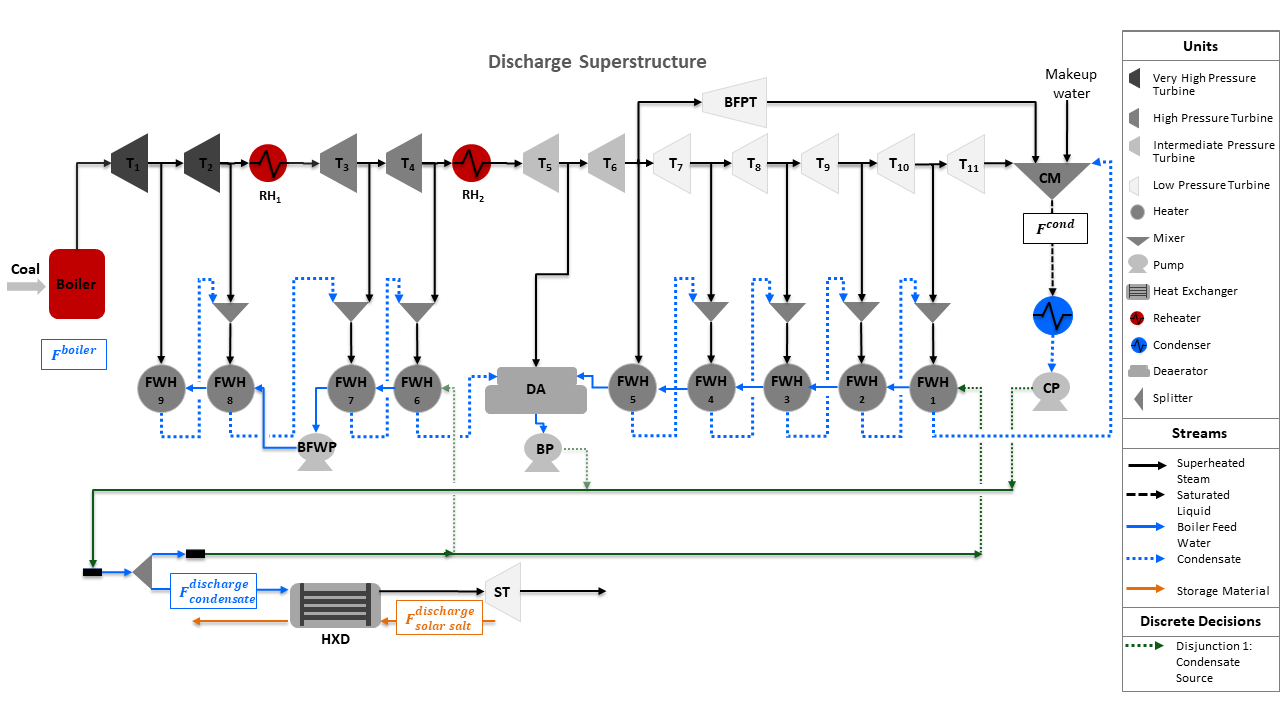

The discharge design model follows the same structure as the charge model. To start its construction, use the same Pyomo and IDAES libraries used in the charge model. Note: since the libraries were already imported during the construction of the design charge  model, there is no need to import them again here. Also, import the discharge design model `discharge_design_ultra_supercritical_power_plant.py`, available in the DISPATCHES repository, as `d_usc`.

In [40]:
from dispatches.models.fossil_case.ultra_supercritical_plant.storage import (
    discharge_design_ultra_supercritical_power_plant as d_usc)

After all the imports, build the ultra-supercritical plant base model, followed by its initialization using the `initialize` method in the power plant model `usc`.

In [41]:
m = usc.build_plant_model()

usc.initialize(m, outlvl=idaeslog.WARNING)

Model Initialization =  optimal
*******************  USC Model Initialized   ********************


Import the Solar salt property package

In [42]:
m.fs.solar_salt_properties = solarsalt_properties.SolarsaltParameterBlock()

Declare a block `discharge` in the flowsheet model to include the units, constraints, and discrete design decisions needed in the discharge storage system. Once built, add the data to the block using the `_add_data` method from the discharge design model `d_usc`.

In [43]:
m.fs.discharge = Block()

d_usc._add_data(m)

Add unit models nedded in the discharge storage system.

In [44]:
m.fs.discharge.hxd = HeatExchanger(
    default={"delta_temperature_callback": delta_temperature_underwood_callback,
             "shell": {"property_package": m.fs.solar_salt_properties},
             "tube": {"property_package": m.fs.prop_water}}
)
m.fs.discharge.es_split = HelmSplitter(
    default={"property_package": m.fs.prop_water,
             "outlet_list": ["to_fwh", "to_hxd"]}
)
m.fs.discharge.es_turbine = HelmTurbineStage(
    default={"property_package": m.fs.prop_water}
)

Using the Solar salt as the storage material in the discharge heat exchanger `HXD`, calculate the overall heat transfer coefficient for the heat exchanger using the method `_solar_salt_ohtc_calculation` from the discharge design model `d_usc`.

In [45]:
d_usc._solar_salt_ohtc_calculation(m)

Connect the discharge heat exchanger to the power plant and to the storage turbine using `Arcs`.

In [46]:
m.fs.discharge.essplit_to_hxd = Arc(
    source=m.fs.discharge.es_split.to_hxd,
    destination=m.fs.discharge.hxd.inlet_2,
    doc="Connection from ES splitter to HXD"
)
m.fs.discharge.hxd_to_esturbine = Arc(
    source=m.fs.discharge.hxd.outlet_2,
    destination=m.fs.discharge.es_turbine.inlet,
    doc="Connection from HXD to ES turbine"
)

Declare the discrete decisions for the condensate source selection as disjuncts using Pyomo `Disjunct` and `Disjunction` modeling objects. Disjunction 1 includes two disjuncts to select between a condensate from the condenser pump `CP` or the booster pump `BP`.

In [47]:
m.fs.discharge.condpump_source_disjunct = Disjunct()
m.fs.discharge.booster_source_disjunct = Disjunct()

m.fs.hxd_source_disjunction = Disjunction(
    expr=[m.fs.discharge.condpump_source_disjunct,
          m.fs.discharge.booster_source_disjunct]
)

Populate disjunct 1 for the selection of the condenser pump as the condensate source by including `Arcs` to connect the condenser pump to the splitter to divert a fraction of the condensate to the discharge storage system. The rest of the condensate is sent back to the feed water 1. 

In [48]:
m.fs.discharge.condpump_source_disjunct.condpump_to_essplit = Arc(
    source=m.fs.cond_pump.outlet,
    destination=m.fs.discharge.es_split.inlet,
    doc="Connection from condenser pump to storage splitter"
)
m.fs.discharge.condpump_source_disjunct.essplit_to_fwh1 = Arc(
    source=m.fs.discharge.es_split.to_fwh,
    destination=m.fs.fwh[1].inlet_2,
    doc="Connection from storage splitter to feed water heater 1"
)
m.fs.discharge.condpump_source_disjunct.booster_to_fwh6 = Arc(
    source=m.fs.booster.outlet,
    destination=m.fs.fwh[6].inlet_2,
    doc="Connection from booster to feed water heater 6"
)

Populate disjunct 2 for the selection of the booster pump as the condensate source by including `Arcs` to connect the booster pump to the splitter to divert a fraction of the condensate to the discharge storage system. The rest of the condensate is sent back to the feed water 6.

In [49]:
m.fs.discharge.booster_source_disjunct.booster_to_essplit = Arc(
    source=m.fs.booster.outlet,
    destination=m.fs.discharge.es_split.inlet,
    doc="Connection from Booster pump to storage splitter"
)
m.fs.discharge.booster_source_disjunct.essplit_to_fwh6 = Arc(
    source=m.fs.discharge.es_split.to_fwh,
    destination=m.fs.fwh[6].inlet_2,
    doc="Connection from storage splitter to feed water heater 6"
)
m.fs.discharge.booster_source_disjunct.condpump_to_fwh1 = Arc(
    source=m.fs.cond_pump.outlet,
    destination=m.fs.fwh[1].inlet_2,
    doc="Connection from condenser pump to feed water heat 1"
)

Once the disjunction is declared, declare a new expression `net_power` to calculate the power plant net power, which accounts for the power produced by the power plant and the storage turbine.  

In [50]:
m.fs.net_power = pyo.Expression(
    expr=(m.fs.plant_power_out[0]
          + (m.fs.discharge.es_turbine.control_volume.work[0] * (-1e-6)))
)

Include four constraints to ensure that the units in the storage system and power plant operate at the desired conditions. Include the first constraint to fix the storage turbine pressure to be at the saturation conditions to ensure a saturated steam in the turbine.

In [51]:
m.fs.discharge.es_turbine.constraint_esturbine_temperature_out = Constraint(
    expr=(
        m.fs.discharge.es_turbine.control_volume.properties_out[0].temperature ==
        m.fs.discharge.es_turbine.control_volume.properties_out[0].temperature_sat
    ),
    doc="Turbine outlet should be a saturated steam"
)

Include three constraints to calculate the fuel heat duty and the boiler and cycle efficiencies.

In [52]:
m.fs.boiler_efficiency = pyo.Var(initialize=0.9,
                                 bounds=(0, 1),
                                 doc="Boiler efficiency")
m.fs.boiler_efficiency_eq = pyo.Constraint(
    expr=m.fs.boiler_efficiency == (
        0.2143 *
        (m.fs.net_power / power_max) +
        0.7357
    ),
)
m.fs.coal_heat_duty = pyo.Var(
    initialize=1000,
    bounds=(0, 1e5),
    doc="Coal heat duty supplied to boiler (MW)")

m.fs.coal_heat_duty_eq = pyo.Constraint(
    expr=m.fs.coal_heat_duty *
    m.fs.boiler_efficiency ==
    m.fs.plant_heat_duty[0]
)

m.fs.cycle_efficiency = pyo.Var(initialize=0.4,
                                bounds=(0, 1),
                                doc="Cycle efficiency")
m.fs.cycle_efficiency_eq = pyo.Constraint(
    expr=(
        m.fs.cycle_efficiency *
        m.fs.coal_heat_duty
    ) == m.fs.net_power,
)

Once all the `Arcs` in the flowsheet are defined, expand them using the Pyomo `TransformationFactory` to create the actual model constraints needed to describe the connections between the units.

In [53]:
expand_arcs.obj_iter_kwds['descend_into'] = (Block, Disjunct)

TransformationFactory("network.expand_arcs").apply_to(m.fs.discharge)

Fix inputs to the model to solve a square problem during initialization. 

In [54]:
m.fs.discharge.hxd.area.fix(2000)

m.fs.discharge.hxd.inlet_1.flow_mass.fix(200)
m.fs.discharge.hxd.inlet_1.temperature.fix(831.15)
m.fs.discharge.hxd.inlet_1.pressure.fix(101325)

m.fs.discharge.es_split.inlet.flow_mol.fix(17854)
m.fs.discharge.es_split.inlet.enth_mol.fix(52232)
m.fs.discharge.es_split.inlet.pressure.fix(3.4958e7)

m.fs.discharge.es_split.split_fraction[0, "to_hxd"].fix(0.2)

m.fs.discharge.es_turbine.constraint_esturbine_temperature_out.deactivate()
m.fs.discharge.es_turbine.outlet.pressure.fix(6896)
m.fs.discharge.es_turbine.efficiency_isentropic.fix(0.8)

Solve initialization of the discharge storage untis. Add the `assert` keyword to check that there are zero degrees of freedom before the solution of initialization flowsheet.

In [55]:
outlvl = idaeslog.WARNING

m.fs.discharge.es_split.initialize(outlvl=outlvl)

propagate_state(m.fs.discharge.essplit_to_hxd)
m.fs.discharge.hxd.initialize(outlvl=outlvl)

propagate_state(m.fs.discharge.hxd_to_esturbine)
m.fs.discharge.es_turbine.initialize(outlvl=outlvl)
m.fs.discharge.es_turbine.constraint_esturbine_temperature_out.activate()
m.fs.discharge.es_turbine.outlet.pressure.unfix()

assert degrees_of_freedom(m) == 0

discharge_init = solver.solve(m)

print(' Discharge initialization solver termination:', discharge_init.solver.termination_condition)

2022-07-07 17:16:31 [INFO] idaes.init.dispatches.models.fossil_case.properties.solarsalt_properties: fs.discharge.hxd.shell.properties_in Initialisation Step 1 Complete.
2022-07-07 17:16:31 [INFO] idaes.init.dispatches.models.fossil_case.properties.solarsalt_properties: Initialization Step 1 Complete.
2022-07-07 17:16:31 [INFO] idaes.init.dispatches.models.fossil_case.properties.solarsalt_properties: fs.discharge.hxd.shell.properties_out Initialisation Step 1 Complete.
2022-07-07 17:16:31 [INFO] idaes.init.dispatches.models.fossil_case.properties.solarsalt_properties: Initialization Step 1 Complete.
2022-07-07 17:16:31 [INFO] idaes.init.dispatches.models.fossil_case.properties.solarsalt_properties: State Released.
2022-07-07 17:16:32 [INFO] idaes.init.dispatches.models.fossil_case.properties.solarsalt_properties: State Released.
 Discharge initialization solver termination: optimal


Add operating and capital costs for the discharge storage system using the method `build_costing` from the discharge design model `d_usc`. This method estimates Solar salt heat exchanger cost using the IDAES costing method with default options. To compute costs that are not included in the costing method, the `build_costing` method includes a set of expressions and constraints for their calculation.

In [56]:
d_usc.build_costing(m, solver=solver)


Cost initialization solver termination: optimal
******************** Costing Initialized *************************




Set lower and upper bounds to flow, energy, and cost variables for all the units in the discharge storage system.

In [57]:
d_usc.add_bounds(m, power_max=power_max)

Disconnect arcs from the ultra-supercritical plant model base model to connect the discharge storage system units.

In [58]:
for arc_s in [m.fs.condpump_to_fwh1,
              m.fs.booster_to_fwh6]:
    arc_s.expanded_block.enth_mol_equality.deactivate()
    arc_s.expanded_block.flow_mol_equality.deactivate()
    arc_s.expanded_block.pressure_equality.deactivate()

To solve the conceptual discharge design problem, unfix inputs that were fixed during initialization. For the discharge storage system, unfix the boiler flow at the inlet and the flow to the storage system splitters, including the inlet flow for the storage heat exchanger. Also, fix the amount of power produced by the plant and the storage heat exchanger heat duty.

In [59]:
m.fs.boiler.inlet.flow_mol.unfix()
m.fs.discharge.es_split.split_fraction[0, "to_hxd"].unfix()
m.fs.discharge.es_split.inlet.unfix()
m.fs.discharge.hxd.inlet_1.flow_mass.unfix()
m.fs.discharge.hxd.area.unfix()

m.fs.plant_power_out.fix(400)
m.fs.boiler.outlet.pressure.fix(m.main_steam_pressure)
m.fs.discharge.hxd.heat_duty.fix(148.5e6)

Include a total cost function that includes only the operating and capital costs of the storage system as the objective function during the design optimization problem.

In [60]:
m.obj = Objective(
    expr=(
        m.fs.discharge.capital_cost +
        m.fs.discharge.operating_cost
    ) * 1e-7
)

Declare the solver to be `gdpopt` and add the desired options to use.

In [61]:
opt = SolverFactory('gdpopt')
opt.CONFIG.strategy = 'LOA'
opt.CONFIG.mip_solver = 'cbc'
opt.CONFIG.nlp_solver = 'ipopt'
opt.CONFIG.init_strategy = "no_init"
_prop_bnds_root_to_leaf_map[ExternalFunctionExpression] = lambda x, y, z: None

Solve the conceptual design of the discharge ultra-supercritical model.

In [62]:
discharge_result = opt.solve(m)

INFO: Original model has 567 constraints (153 nonlinear) and 1 disjunctions,
    with 562 variables, of which 2 are binary, 0 are integer, and 560 are
    continuous.
INFO: Starting GDPopt version 20.2.28 using LOA algorithm
INFO: Subsolvers:
    - MILP: cbc
    - NLP: ipopt
    - MINLP: baron
    - local MINLP: bonmin
INFO: If you use this software, you may cite the following:
    - Implementation:
    Chen, Q; Johnson, ES; Bernal, DE; Valentin, R; Kale, S; Bates, J; Siirola,
    JD; Grossmann, IE. Pyomo.GDP: an ecosystem for logic based modeling and
    optimization development. Optimization and Engineering, 2021.
    - LOA algorithm:
    Türkay, M; Grossmann, IE. Logic-based MINLP algorithms for the optimal
    synthesis of process networks. Comp. and Chem. Eng. 1996, 20(8), 959–978.
    DOI: 10.1016/0098-1354(95)00219-7.
INFO: ---Starting GDPopt initialization---
INFO: ---GDPopt Master Iteration 1---
INFO: ITER 1.1.0-MIP: OBJ: 0  LB: 0  UB: inf
INFO: Solving nonlinear subproblem fo

Print the optimal discharge design

In [63]:
print("**Discrete design decisions (Disjunction)")
for d in m.component_data_objects(ctype=Disjunct,
                                  active=True,
                                  sort=True, descend_into=True):
    if abs(d.binary_indicator_var.value - 1) < 1e-6:
        print(d.name, ' should be selected!')

**Discrete design decisions (Disjunction)
fs.discharge.booster_source_disjunct  should be selected!
